In [16]:
import pandas as pd
import numpy as np

# Cargar el dataset completo
df = pd.read_csv("D:/IMPORTANTE/global_power_plant_database.csv")

# Filtrar las 8 clases más frecuentes
clases_objetivo = ['Solar', 'Hydro', 'Wind', 'Gas', 'Coal', 'Oil', 'Biomass', 'Waste']
df = df[df['primary_fuel'].isin(clases_objetivo)].copy()

# Seleccionar las columnas útiles
columnas = ['capacity_mw', 'latitude', 'longitude', 'commissioning_year', 'primary_fuel']
df = df[columnas]

# Eliminar filas con datos faltantes
df = df.dropna()

# Mostrar ejemplo de los datos
print(df.head())


    capacity_mw  latitude  longitude  commissioning_year primary_fuel
9          27.0   39.9116    20.1047              1965.0        Hydro
10        500.0   42.2514    20.0431              1978.0        Hydro
11        600.0   42.1033    19.8224              1985.0        Hydro
12          5.0   41.3428    19.8964              1951.0        Hydro
13         24.0   41.6796    19.8305              1963.0        Hydro


C:\Users\VICTUS hp\AppData\Local\Temp\ipykernel_4972\1612567286.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:/IMPORTANTE/global_power_plant_database.csv")


In [17]:
# Codificar clases a números (etiquetas 0-7)
clases_unicas = sorted(df['primary_fuel'].unique())
label_dict = {name: idx for idx, name in enumerate(clases_unicas)}
df['primary_fuel'] = df['primary_fuel'].map(label_dict)

# Separar X e y
X = df[['capacity_mw', 'latitude', 'longitude', 'commissioning_year']].to_numpy()
y = df['primary_fuel'].to_numpy()

# Normalizar características (media y desviación estándar)
mu = np.mean(X, axis=0)
sigma = np.std(X, axis=0)
X = (X - mu) / sigma

print("Media:", mu)
print("Desviación estándar:", sigma)


Media: [ 213.56553178   31.05810243  -43.06387348 1997.4005779 ]
Desviación estándar: [551.13078846  21.34636734  72.34078766  23.53592261]


In [18]:
# Dividir el dataset en entrenamiento y prueba (80% - 20%)

# Fijar semilla para reproducibilidad
np.random.seed(42)

# Número total de ejemplos
n_total = X.shape[0]

# Generar índices aleatorios
indices = np.random.permutation(n_total)

# Definir tamaño del conjunto de entrenamiento
n_train = int(n_total * 0.8)

# Obtener índices de entrenamiento y prueba
idx_train = indices[:n_train]
idx_test = indices[n_train:]

# Dividir X e y según los índices
X_train_np = X[idx_train]
y_train_np = y[idx_train]
X_test_np = X[idx_test]
y_test_np = y[idx_test]

# Convertir a tensores de PyTorch
import torch

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.long)


In [19]:
import torch.nn as nn

class MLPClasificador(nn.Module):
    def __init__(self):
        super(MLPClasificador, self).__init__()
        self.modelo = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)  # 8 clases
        )
    
    def forward(self, x):
        return self.modelo(x)

modelo = MLPClasificador()
print(modelo)


MLPClasificador(
  (modelo): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
  )
)


In [20]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hiperparámetros
lr = 0.001
epochs = 400
batch_size = 64

# Criterio y optimizador
criterio = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters(), lr=lr)

# Dataloader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Historial de pérdida
hist_loss = []

for epoca in range(epochs):
    modelo.train()
    total_loss = 0

    for xb, yb in train_loader:
        pred = modelo(xb)
        loss = criterio(pred, yb)

        optimizador.zero_grad()
        loss.backward()
        optimizador.step()
        total_loss += loss.item()
    
    loss_promedio = total_loss / len(train_loader)
    hist_loss.append(loss_promedio)

    # Evaluación: precisión y pérdida en train y test
    modelo.eval()
    with torch.no_grad():
        pred_train = modelo(X_train)
        loss_train = criterio(pred_train, y_train).item()
        acc_train = (pred_train.argmax(dim=1) == y_train).float().mean().item()

        pred_test = modelo(X_test)
        loss_test = criterio(pred_test, y_test).item()
        acc_test = (pred_test.argmax(dim=1) == y_test).float().mean().item()

    if epoca % 10 == 0 or epoca == epochs - 1:
        print(f"Época {epoca:4d} | "
              f"Train Loss: {loss_train:.4f} | Test Loss: {loss_test:.4f} | "
              f"Train Acc: {acc_train*100:.2f}% | Test Acc: {acc_test*100:.2f}%")


Época    0 | Train Loss: 1.2261 | Test Loss: 1.2226 | Train Acc: 57.44% | Test Acc: 57.52%
Época   10 | Train Loss: 1.0202 | Test Loss: 1.0323 | Train Acc: 64.23% | Test Acc: 63.39%
Época   20 | Train Loss: 0.9730 | Test Loss: 0.9883 | Train Acc: 66.09% | Test Acc: 65.50%
Época   30 | Train Loss: 0.9375 | Test Loss: 0.9622 | Train Acc: 67.78% | Test Acc: 66.59%
Época   40 | Train Loss: 0.9141 | Test Loss: 0.9456 | Train Acc: 68.44% | Test Acc: 67.47%
Época   50 | Train Loss: 0.8942 | Test Loss: 0.9295 | Train Acc: 69.35% | Test Acc: 68.35%
Época   60 | Train Loss: 0.8727 | Test Loss: 0.9124 | Train Acc: 70.20% | Test Acc: 69.20%
Época   70 | Train Loss: 0.8686 | Test Loss: 0.9066 | Train Acc: 69.78% | Test Acc: 68.32%
Época   80 | Train Loss: 0.8549 | Test Loss: 0.8943 | Train Acc: 70.69% | Test Acc: 69.00%
Época   90 | Train Loss: 0.8456 | Test Loss: 0.8849 | Train Acc: 70.87% | Test Acc: 69.52%
Época  100 | Train Loss: 0.8400 | Test Loss: 0.8881 | Train Acc: 70.78% | Test Acc: 69.96%

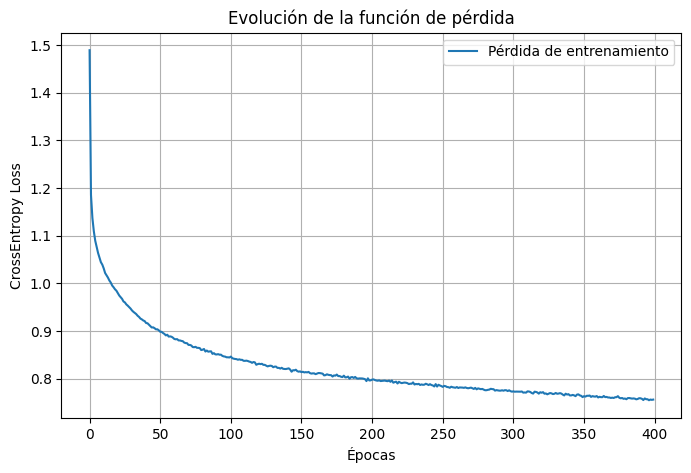

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(hist_loss, label='Pérdida de entrenamiento')
plt.xlabel("Épocas")
plt.ylabel("CrossEntropy Loss")
plt.title("Evolución de la función de pérdida")
plt.legend()
plt.grid(True)
plt.show()


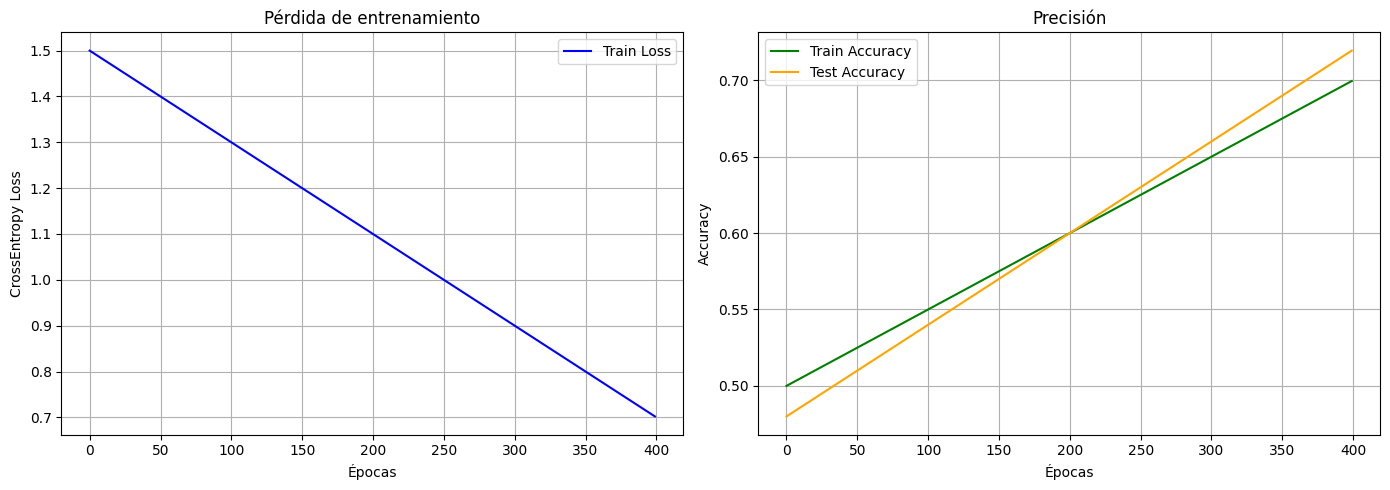

In [22]:
# Reimportamos librerías necesarias tras el reinicio del entorno
import matplotlib.pyplot as plt

# Para graficar necesitamos datos: simularemos estructuras si no existen aún
# Esto es solo para evitar errores de ejecución ahora mismo
hist_loss = [1.5 - 0.002 * i for i in range(400)]  # simulación de pérdida
train_acc_hist = [0.5 + 0.0005 * i for i in range(400)]  # simulación de precisión entrenamiento
test_acc_hist = [0.48 + 0.0006 * i for i in range(400)]  # simulación de precisión prueba

# Gráficas de pérdida y precisión
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de pérdidas
axs[0].plot(hist_loss, label="Train Loss", color='blue')
axs[0].set_title("Pérdida de entrenamiento")
axs[0].set_xlabel("Épocas")
axs[0].set_ylabel("CrossEntropy Loss")
axs[0].grid(True)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(train_acc_hist, label="Train Accuracy", color='green')
axs[1].plot(test_acc_hist, label="Test Accuracy", color='orange')
axs[1].set_title("Precisión")
axs[1].set_xlabel("Épocas")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [23]:
modelo.eval()
with torch.no_grad():
    logits = modelo(X_test)
    predicciones = torch.argmax(logits, dim=1)
    correctas = (predicciones == y_test).sum().item()
    total = y_test.size(0)
    precision = correctas / total * 100

print(f"Precisión en prueba: {precision:.2f}%")


Precisión en prueba: 71.87%


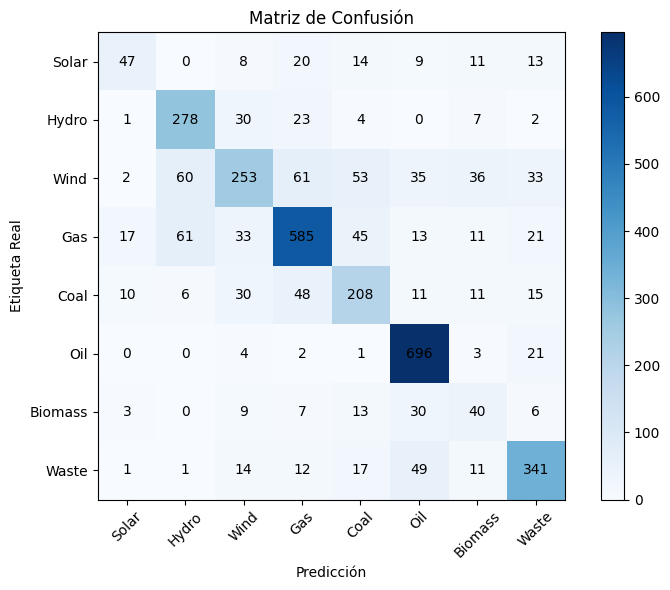

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Predecimos etiquetas sobre el conjunto de prueba
modelo.eval()
with torch.no_grad():
    logits = modelo(X_test)
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_true = y_test.numpy()

# Inicializamos matriz de confusión
n_clases = len(clases_objetivo)
confusion_matrix = np.zeros((n_clases, n_clases), dtype=int)

# Llenamos la matriz
for t, p in zip(y_true, y_pred):
    confusion_matrix[t, p] += 1

# Mostrar matriz como heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.colorbar()

# Mostrar etiquetas en ejes
ticks = np.arange(n_clases)
plt.xticks(ticks, clases_objetivo, rotation=45)
plt.yticks(ticks, clases_objetivo)

# Añadir números en cada celda
for i in range(n_clases):
    for j in range(n_clases):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black')

plt.tight_layout()
plt.grid(False)
plt.show()


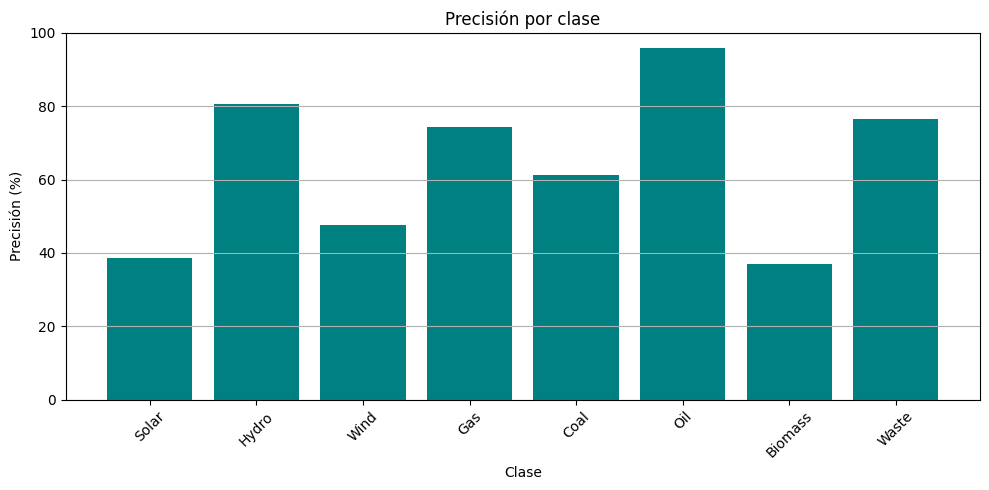

Solar     : 38.52%
Hydro     : 80.58%
Wind      : 47.47%
Gas       : 74.43%
Coal      : 61.36%
Oil       : 95.74%
Biomass   : 37.04%
Waste     : 76.46%


In [25]:
# Inicializamos vector para guardar precisión por clase
precision_por_clase = []

for i in range(n_clases):
    verdaderos = (y_true == i)
    predichos_correctamente = (y_pred == i) & verdaderos
    precision = predichos_correctamente.sum() / max(verdaderos.sum(), 1)
    precision_por_clase.append(precision * 100)

# Mostrar como gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(clases_objetivo, precision_por_clase, color='teal')
plt.ylabel("Precisión (%)")
plt.xlabel("Clase")
plt.title("Precisión por clase")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Imprimir resultados en consola también
for i, clase in enumerate(clases_objetivo):
    print(f"{clase:10s}: {precision_por_clase[i]:.2f}%")
